# PRL paper: https://journals-aps-org.libaccess.sjlibrary.org/prl/pdf/10.1103/PhysRevLett.126.213601

# Supplemental Material: https://journals-aps-org.libaccess.sjlibrary.org/prl/supplemental/10.1103/PhysRevLett.126.213601/SiVcompare_SM8edits2.pdf

# article of nice plots: https://towardsdatascience.com/how-to-create-and-use-custom-matplotlib-style-sheet-9393f498063

In [42]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import numba
import scipy.integrate as spint
import cmath
# plt.style.use('seaborn-pastel')
mpl.rcParams['font.family'] = 'sans-serif'
COLOR = 'k'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR
mpl.rcParams['axes.edgecolor'] = 'k'
SIZE = 8
mpl.rcParams['font.size'] = SIZE
mpl.rcParams['legend.fontsize'] = SIZE
mpl.rcParams['figure.titlesize'] = SIZE
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['savefig.dpi'] = 800

# rcParams parameters https://matplotlib.org/stable/users/dflt_style_changes.html

# parameters

## caption of FIG. S9

# $ \sigma = 0.2 \, \omega_{10}^{(unstrained)} \newline \gamma_{10} = 0.05 \, \sigma $

# $ \gamma_{10} = \frac{1}{2} \left( \Gamma_{10} + \Gamma_{12} \right) + \gamma_c \, \, \, \, \, \, \text{with} \, \, \, \, \, \, \gamma_c \gg \frac{1}{2} \left( \Gamma_{10} + \Gamma_{12} \right) \tag{s7}$

In [43]:
hbar = 1.
mu = 1.
N = 1.
omega12 = 1.
omega10_unstrained = 2. * np.pi

sigma = 0.2 * omega10_unstrained
gamma10 = 0.05 * sigma
Gamma10 = gamma10 * 1E-5

Delta_gs = 0.25
Delta_es = 2.5

# colorbar function

In [44]:
# @numba.jit
def colorbar(mappable, label='arb. units'):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    if label is not None:
        plt.ylabel(label)
    plt.sca(last_axes)
    return cbar

 # complex square function

In [45]:
@numba.vectorize([numba.float64(numba.complex128),numba.float32(numba.complex64)])
def abs2(x):
    return x.real**2 + x.imag**2

# complex phase

In [46]:
@numba.vectorize([numba.float64(numba.complex128),numba.float32(numba.complex64)])
def phi(x):
    return cmath.phase(x)

# creating mesh

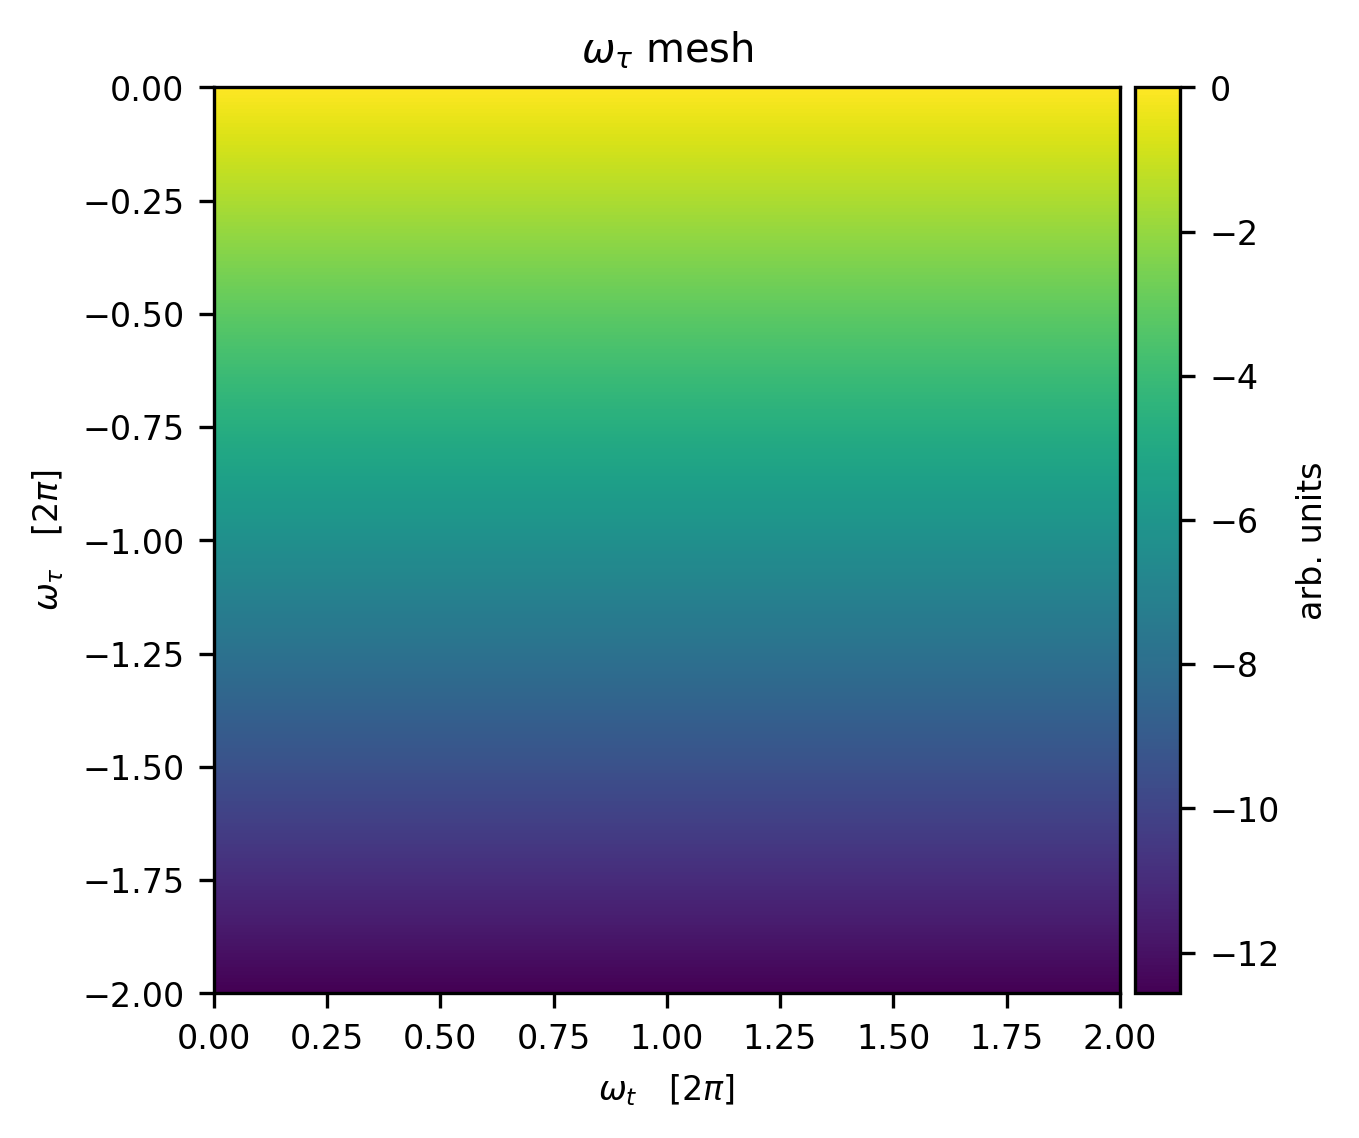

In [47]:
omega_t = np.linspace(0., 4.*np.pi, 500)
omega_tau = np.linspace(-4.*np.pi, 0., 500)
omega_t_mesh, omega_tau_mesh = np.meshgrid(omega_t, omega_tau, indexing='xy')
plt.figure()
im = plt.imshow(omega_tau_mesh, 
                origin='lower', 
                extent=(min(omega_t / 2. / np.pi), 
                        max(omega_t / 2. / np.pi), 
                        min(omega_tau / 2. / np.pi), 
                        max(omega_tau / 2. / np.pi)))
plt.xlabel(r'$\omega_t \quad [2 \pi] $')
plt.ylabel(r'$\omega_\tau \quad [2 \pi] $')
plt.title(r'$\omega_\tau$ mesh')
colorbar(im)
plt.show()

# multiple plot function

In [48]:
# @numba.jit
def slices_plots(
        databox,
        titles=None,
        figure_shape=[4, 4],
        figure_size=(11, 10),
        vertical_gap=0.15,
        horizontal_gap=0.15,
        shared_x_label=r'$\omega_t \quad [2 \pi] $',
        shared_x_label_x_position=0.515,
        shared_x_label_y_position=0.09,
        shared_y_label=r'$\omega_\tau \quad [2 \pi] $',
        shared_y_label_x_position=0.08,
        shared_y_label_y_position=0.5,
        shared_title=r'$\mathfrak{R} \left\{ \rho^{(3)}_{10,sig} (\omega_t, \omega_\tau) \right\}$',
        shared_title_x_position=0.515,
        shared_title_y_position=0.93,
        share_x_axis=True,
        share_y_axis=True,
        colorbar_labels='arb. units', 
        EXTENT=(min(omega_t / 2. / np.pi),
                max(omega_t / 2. / np.pi), 
                min(omega_tau / 2. / np.pi), 
                max(omega_tau / 2. / np.pi))
        ):

    fig, ax = plt.subplots(
        figure_shape[0],  # row
        figure_shape[1],  # column
        figsize=figure_size,
        sharex=share_x_axis,
        sharey=share_y_axis,
        gridspec_kw={
            "hspace": vertical_gap,
            'wspace': horizontal_gap
        })

    if titles is None:
        titles = [r'$\omega_{10} =$' f'{i / np.pi:.2f} $\pi$' for i in omega_10_vals]

    for i in range(np.shape(databox)[0]):
        im = ax.flatten()[i].imshow(
            databox[i].T,
            origin='lower',
            extent=EXTENT
        )
        ax.flatten()[i].set_title(titles[i])
            
        if np.size(colorbar_labels)==1:
            if (i+1)%figure_shape[1]:
                colorbar(im, None)
            else:
                colorbar(im, colorbar_labels)
        else:
            colorbar(im, colorbar_labels[i])

    fig.suptitle(x=shared_title_x_position,
                 y=shared_title_y_position,
                 t=shared_title,
                 ha='center',
                 size=1.5*SIZE)

    if shared_x_label != None:  # shared x label
        fig.text(x=shared_x_label_x_position,
                 y=shared_x_label_y_position,
                 s=shared_x_label,
                 ha='center')

    if shared_y_label != None:  # shared y label
        fig.text(x=shared_y_label_x_position,
                 y=shared_y_label_y_position,
                 s=shared_y_label,
                 va='center',
                 rotation='vertical')

    plt.show()
    return fig

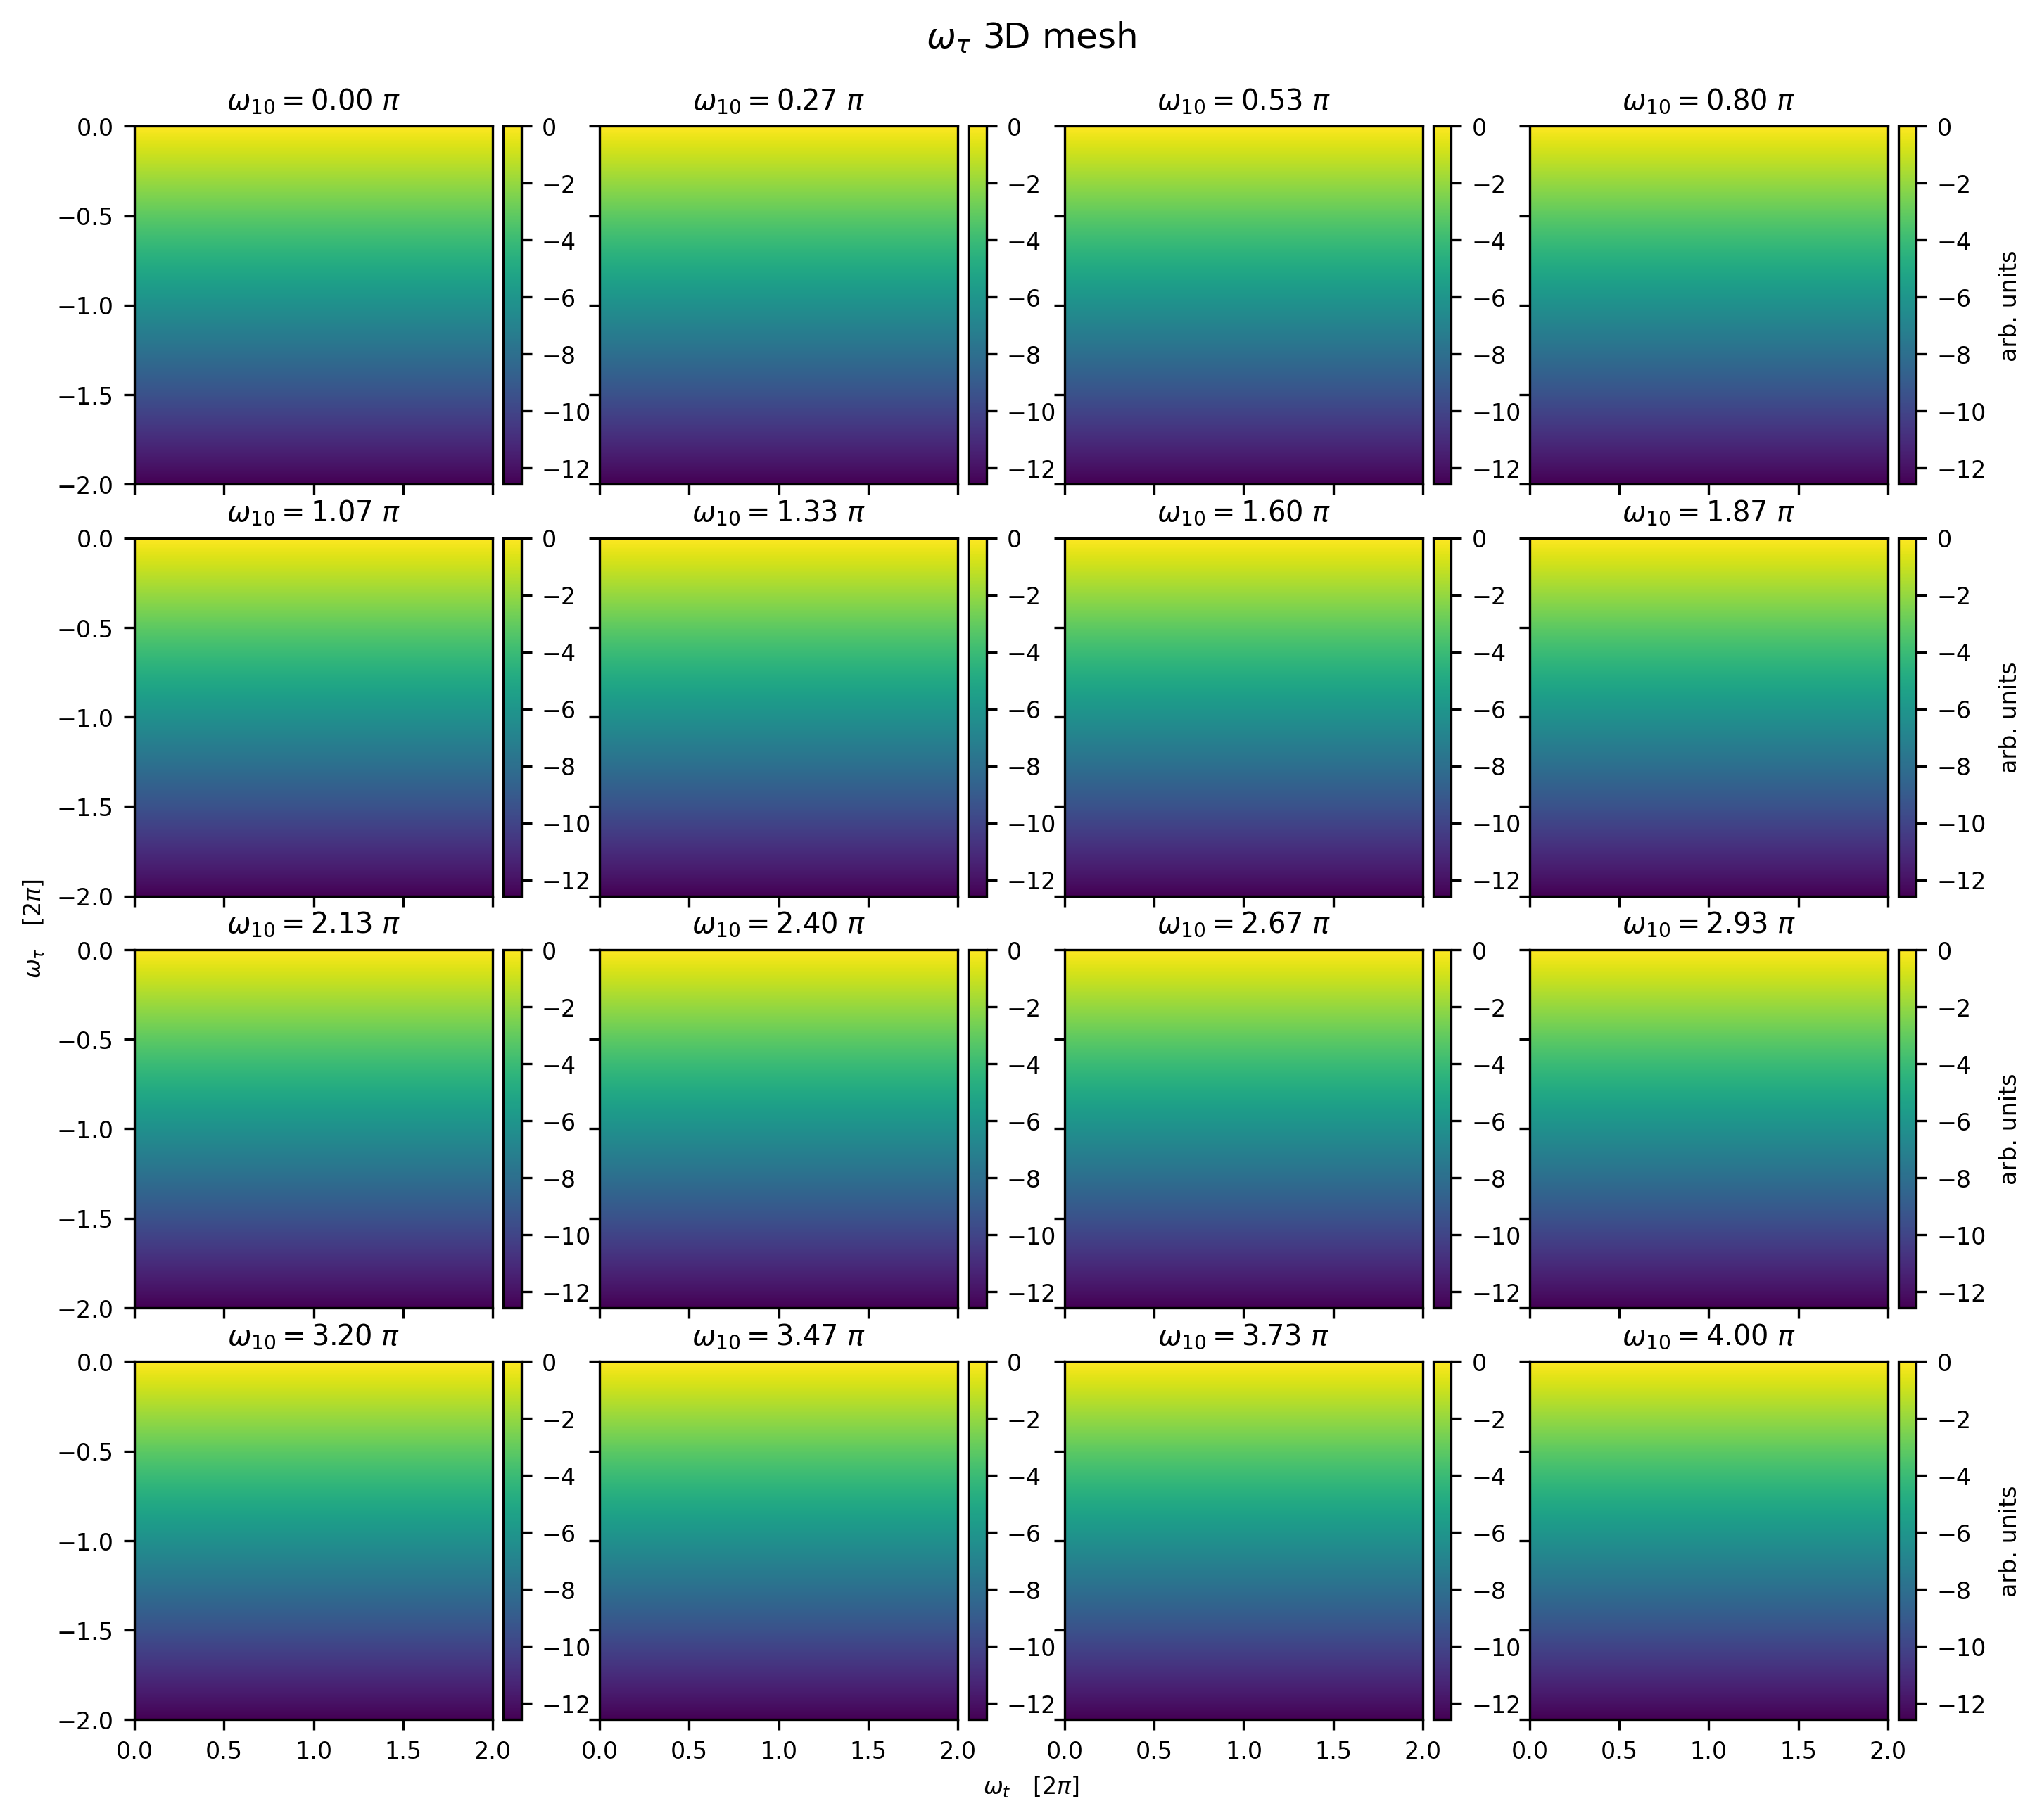

In [49]:
omega_10_vals = np.linspace(0. , 4. * np.pi, 16)
omega_10_3Dmesh, omega_t_3Dmesh, omega_tau_3Dmesh = np.meshgrid(omega_10_vals, 
                                                                omega_t, 
                                                                omega_tau, 
                                                                indexing='ij')

_ = slices_plots(omega_tau_3Dmesh, shared_title=r'$\omega_\tau$ 3D mesh')

# density matrix element

## index 10, 3rd order correction

# $ \rho^{(3)}_{10,sig} (\omega_t, \omega_\tau) = -\frac{\mathcal{i} |\mu|^2 \mu }{8 \hbar^3} \left( \frac{i}{\omega_t - \left[ \omega_{10} - \mathcal{i} \gamma_{10} \right] } \right) \left( \frac{\mathcal{i}}{\omega_\tau - \left[ -\omega_{10} - i \gamma_{10} \right] } \right) \tag{s11} $

# Modified density matrix element

# $ \rho^{(3)}_{10,sig} (\omega_t, \omega_\tau) = -\frac{\mathcal{i} |\mu|^2 \mu }{8 \hbar^3} \left [ \newline
\phantom{+} \left( \frac{i}{\omega_t - \left[ \omega_{10} \, \mathbf{\oplus} \, \left ( \Delta_{gs} \, \mathbf{\oplus} \, \Delta_{es} \right ) - \mathcal{i} \gamma_{10} \right] } \right)
            \left( \frac{\mathcal{i}}{\omega_\tau - \left[ - \left \{ \omega_{10} \, \mathbf{\oplus} \, \left ( \Delta_{gs} \, \mathbf{\oplus} \, \Delta_{es} \right ) \right \} - i \gamma_{10} \right] } \right)
          + \left( \frac{i}{\omega_t - \left[ \omega_{10} \, \mathbf{\oplus} \, \left ( \Delta_{gs} \, \mathbf{\oplus} \, \Delta_{es} \right ) - \mathcal{i} \gamma_{10} \right] } \right)
            \left( \frac{\mathcal{i}}{\omega_\tau - \left[ - \left \{ \omega_{10} \, \mathbf{\oplus} \, \left ( \Delta_{gs} \, \mathbf{\ominus} \, \Delta_{es} \right ) \right \} - i \gamma_{10} \right] } \right)
          + \left( \frac{i}{\omega_t - \left[ \omega_{10} \, \mathbf{\oplus} \, \left ( \Delta_{gs} \, \mathbf{\oplus} \, \Delta_{es} \right ) - \mathcal{i} \gamma_{10} \right] } \right)
            \left( \frac{\mathcal{i}}{\omega_\tau - \left[ - \left \{ \omega_{10} \, \mathbf{\ominus} \, \left ( \Delta_{gs} \, \mathbf{\oplus} \, \Delta_{es} \right ) \right \} - i \gamma_{10} \right] } \right)
          + \left( \frac{i}{\omega_t - \left[ \omega_{10} \, \mathbf{\oplus} \, \left ( \Delta_{gs} \, \mathbf{\oplus} \, \Delta_{es} \right ) - \mathcal{i} \gamma_{10} \right] } \right)
            \left( \frac{\mathcal{i}}{\omega_\tau - \left[ - \left \{ \omega_{10} \, \mathbf{\ominus} \, \left ( \Delta_{gs} \, \mathbf{\ominus} \, \Delta_{es} \right ) \right \} - i \gamma_{10} \right] } \right)
          + \left( \frac{i}{\omega_t - \left[ \omega_{10} \, \mathbf{\oplus} \, \left ( \Delta_{gs} \, \mathbf{\ominus} \, \Delta_{es} \right ) - \mathcal{i} \gamma_{10} \right] } \right)
            \left( \frac{\mathcal{i}}{\omega_\tau - \left[ - \left \{ \omega_{10} \, \mathbf{\oplus} \, \left ( \Delta_{gs} \, \mathbf{\oplus} \, \Delta_{es} \right ) \right \} - i \gamma_{10} \right] } \right)
          + \left( \frac{i}{\omega_t - \left[ \omega_{10} \, \mathbf{\oplus} \, \left ( \Delta_{gs} \, \mathbf{\ominus} \, \Delta_{es} \right ) - \mathcal{i} \gamma_{10} \right] } \right)
            \left( \frac{\mathcal{i}}{\omega_\tau - \left[ - \left \{ \omega_{10} \, \mathbf{\oplus} \, \left ( \Delta_{gs} \, \mathbf{\ominus} \, \Delta_{es} \right ) \right \} - i \gamma_{10} \right] } \right)
          + \left( \frac{i}{\omega_t - \left[ \omega_{10} \, \mathbf{\oplus} \, \left ( \Delta_{gs} \, \mathbf{\ominus} \, \Delta_{es} \right ) - \mathcal{i} \gamma_{10} \right] } \right)
            \left( \frac{\mathcal{i}}{\omega_\tau - \left[ - \left \{ \omega_{10} \, \mathbf{\ominus} \, \left ( \Delta_{gs} \, \mathbf{\oplus} \, \Delta_{es} \right ) \right \} - i \gamma_{10} \right] } \right)
          + \left( \frac{i}{\omega_t - \left[ \omega_{10} \, \mathbf{\oplus} \, \left ( \Delta_{gs} \, \mathbf{\ominus} \, \Delta_{es} \right ) - \mathcal{i} \gamma_{10} \right] } \right)
            \left( \frac{\mathcal{i}}{\omega_\tau - \left[ - \left \{ \omega_{10} \, \mathbf{\ominus} \, \left ( \Delta_{gs} \, \mathbf{\ominus} \, \Delta_{es} \right ) \right \} - i \gamma_{10} \right] } \right)
          + \left( \frac{i}{\omega_t - \left[ \omega_{10} \, \mathbf{\ominus} \, \left ( \Delta_{gs} \, \mathbf{\oplus} \, \Delta_{es} \right ) - \mathcal{i} \gamma_{10} \right] } \right)
            \left( \frac{\mathcal{i}}{\omega_\tau - \left[ - \left \{ \omega_{10} \, \mathbf{\oplus} \, \left ( \Delta_{gs} \, \mathbf{\oplus} \, \Delta_{es} \right ) \right \} - i \gamma_{10} \right] } \right)
          + \left( \frac{i}{\omega_t - \left[ \omega_{10} \, \mathbf{\ominus} \, \left ( \Delta_{gs} \, \mathbf{\oplus} \, \Delta_{es} \right ) - \mathcal{i} \gamma_{10} \right] } \right)
            \left( \frac{\mathcal{i}}{\omega_\tau - \left[ - \left \{ \omega_{10} \, \mathbf{\oplus} \, \left ( \Delta_{gs} \, \mathbf{\ominus} \, \Delta_{es} \right ) \right \} - i \gamma_{10} \right] } \right)
          + \left( \frac{i}{\omega_t - \left[ \omega_{10} \, \mathbf{\ominus} \, \left ( \Delta_{gs} \, \mathbf{\oplus} \, \Delta_{es} \right ) - \mathcal{i} \gamma_{10} \right] } \right)
            \left( \frac{\mathcal{i}}{\omega_\tau - \left[ - \left \{ \omega_{10} \, \mathbf{\ominus} \, \left ( \Delta_{gs} \, \mathbf{\oplus} \, \Delta_{es} \right ) \right \} - i \gamma_{10} \right] } \right)
          + \left( \frac{i}{\omega_t - \left[ \omega_{10} \, \mathbf{\ominus} \, \left ( \Delta_{gs} \, \mathbf{\oplus} \, \Delta_{es} \right ) - \mathcal{i} \gamma_{10} \right] } \right)
            \left( \frac{\mathcal{i}}{\omega_\tau - \left[ - \left \{ \omega_{10} \, \mathbf{\ominus} \, \left ( \Delta_{gs} \, \mathbf{\ominus} \, \Delta_{es} \right ) \right \} - i \gamma_{10} \right] } \right)
          + \left( \frac{i}{\omega_t - \left[ \omega_{10} \, \mathbf{\ominus} \, \left ( \Delta_{gs} \, \mathbf{\ominus} \, \Delta_{es} \right ) - \mathcal{i} \gamma_{10} \right] } \right)
            \left( \frac{\mathcal{i}}{\omega_\tau - \left[ - \left \{ \omega_{10} \, \mathbf{\oplus} \, \left ( \Delta_{gs} \, \mathbf{\oplus} \, \Delta_{es} \right ) \right \} - i \gamma_{10} \right] } \right)
          + \left( \frac{i}{\omega_t - \left[ \omega_{10} \, \mathbf{\ominus} \, \left ( \Delta_{gs} \, \mathbf{\ominus} \, \Delta_{es} \right ) - \mathcal{i} \gamma_{10} \right] } \right)
            \left( \frac{\mathcal{i}}{\omega_\tau - \left[ - \left \{ \omega_{10} \, \mathbf{\oplus} \, \left ( \Delta_{gs} \, \mathbf{\ominus} \, \Delta_{es} \right ) \right \} - i \gamma_{10} \right] } \right)
          + \left( \frac{i}{\omega_t - \left[ \omega_{10} \, \mathbf{\ominus} \, \left ( \Delta_{gs} \, \mathbf{\ominus} \, \Delta_{es} \right ) - \mathcal{i} \gamma_{10} \right] } \right)
            \left( \frac{\mathcal{i}}{\omega_\tau - \left[ - \left \{ \omega_{10} \, \mathbf{\ominus} \, \left ( \Delta_{gs} \, \mathbf{\oplus} \, \Delta_{es} \right ) \right \} - i \gamma_{10} \right] } \right)
          + \left( \frac{i}{\omega_t - \left[ \omega_{10} \, \mathbf{\ominus} \, \left ( \Delta_{gs} \, \mathbf{\ominus} \, \Delta_{es} \right ) - \mathcal{i} \gamma_{10} \right] } \right)
            \left( \frac{\mathcal{i}}{\omega_\tau - \left[ - \left \{ \omega_{10} \, \mathbf{\ominus} \, \left ( \Delta_{gs} \, \mathbf{\ominus} \, \Delta_{es} \right ) \right \} - i \gamma_{10} \right] } \right) \right ] $ $ \tag{Mod.s11} $          

In [50]:
@numba.jit
def rho_10_sig_3(omega_t, omega_tau, omega10):
#     return -1j * abs2(mu) * mu / 8. / hbar**3. * (1j / (omega_t - (omega10 - 1j*gamma10))) * (1j / (omega_tau - (-omega10 - 1j*gamma10)))
    return -1j * abs2(mu) * mu / 8. / hbar**3. * np.sum([ (1j / (omega_t - (omega10 + (Delta_gs + Delta_es) - 1j*gamma10))) * (1j / (omega_tau - (-(omega10 + (Delta_gs + Delta_es)) - 1j*gamma10))), 
                                                          (1j / (omega_t - (omega10 + (Delta_gs + Delta_es) - 1j*gamma10))) * (1j / (omega_tau - (-(omega10 + (Delta_gs - Delta_es)) - 1j*gamma10))), 
                                                          (1j / (omega_t - (omega10 + (Delta_gs + Delta_es) - 1j*gamma10))) * (1j / (omega_tau - (-(omega10 - (Delta_gs + Delta_es)) - 1j*gamma10))), 
                                                          (1j / (omega_t - (omega10 + (Delta_gs + Delta_es) - 1j*gamma10))) * (1j / (omega_tau - (-(omega10 - (Delta_gs - Delta_es)) - 1j*gamma10))), 
                                                          (1j / (omega_t - (omega10 + (Delta_gs - Delta_es) - 1j*gamma10))) * (1j / (omega_tau - (-(omega10 + (Delta_gs + Delta_es)) - 1j*gamma10))), 
                                                          (1j / (omega_t - (omega10 + (Delta_gs - Delta_es) - 1j*gamma10))) * (1j / (omega_tau - (-(omega10 + (Delta_gs - Delta_es)) - 1j*gamma10))),
                                                          (1j / (omega_t - (omega10 + (Delta_gs - Delta_es) - 1j*gamma10))) * (1j / (omega_tau - (-(omega10 - (Delta_gs + Delta_es)) - 1j*gamma10))), 
                                                          (1j / (omega_t - (omega10 + (Delta_gs - Delta_es) - 1j*gamma10))) * (1j / (omega_tau - (-(omega10 - (Delta_gs - Delta_es)) - 1j*gamma10))), 
                                                          (1j / (omega_t - (omega10 - (Delta_gs + Delta_es) - 1j*gamma10))) * (1j / (omega_tau - (-(omega10 + (Delta_gs + Delta_es)) - 1j*gamma10))), 
                                                          (1j / (omega_t - (omega10 - (Delta_gs + Delta_es) - 1j*gamma10))) * (1j / (omega_tau - (-(omega10 + (Delta_gs - Delta_es)) - 1j*gamma10))), 
                                                          (1j / (omega_t - (omega10 - (Delta_gs + Delta_es) - 1j*gamma10))) * (1j / (omega_tau - (-(omega10 - (Delta_gs + Delta_es)) - 1j*gamma10))),
                                                          (1j / (omega_t - (omega10 - (Delta_gs + Delta_es) - 1j*gamma10))) * (1j / (omega_tau - (-(omega10 - (Delta_gs - Delta_es)) - 1j*gamma10))), 
                                                          (1j / (omega_t - (omega10 - (Delta_gs - Delta_es) - 1j*gamma10))) * (1j / (omega_tau - (-(omega10 + (Delta_gs + Delta_es)) - 1j*gamma10))), 
                                                          (1j / (omega_t - (omega10 - (Delta_gs - Delta_es) - 1j*gamma10))) * (1j / (omega_tau - (-(omega10 + (Delta_gs - Delta_es)) - 1j*gamma10))), 
                                                          (1j / (omega_t - (omega10 - (Delta_gs - Delta_es) - 1j*gamma10))) * (1j / (omega_tau - (-(omega10 - (Delta_gs + Delta_es)) - 1j*gamma10))),
                                                          (1j / (omega_t - (omega10 - (Delta_gs - Delta_es) - 1j*gamma10))) * (1j / (omega_tau - (-(omega10 - (Delta_gs - Delta_es)) - 1j*gamma10)))
                                                        ], 0)

/var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_4503/2122550010.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "rho_10_sig_3" failed type inference due to: No implementation of function Function(<function sum at 0x7fe917422af0>) found for signature:
 
 >>> sum(list(array(complex128, 3d, C))<iv=None>, Literal[int](0))
 
There are 2 candidate implementations:
      - Of which 2 did not match due to:
      Overload of function 'sum': File: numba/core/typing/npydecl.py: Line 348.
        With argument(s): '(list(array(complex128, 3d, C))<iv=None>, Literal[int](0))':
       No match.

During: resolving callee type: Function(<function sum at 0x7fe917422af0>)
During: typing of call at /var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_4503/2122550010.py (4)


File "../../../../../../var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_4503/2122550010.py", line 4:
<source missing, REPL/exec in use?>

  @numba.ji

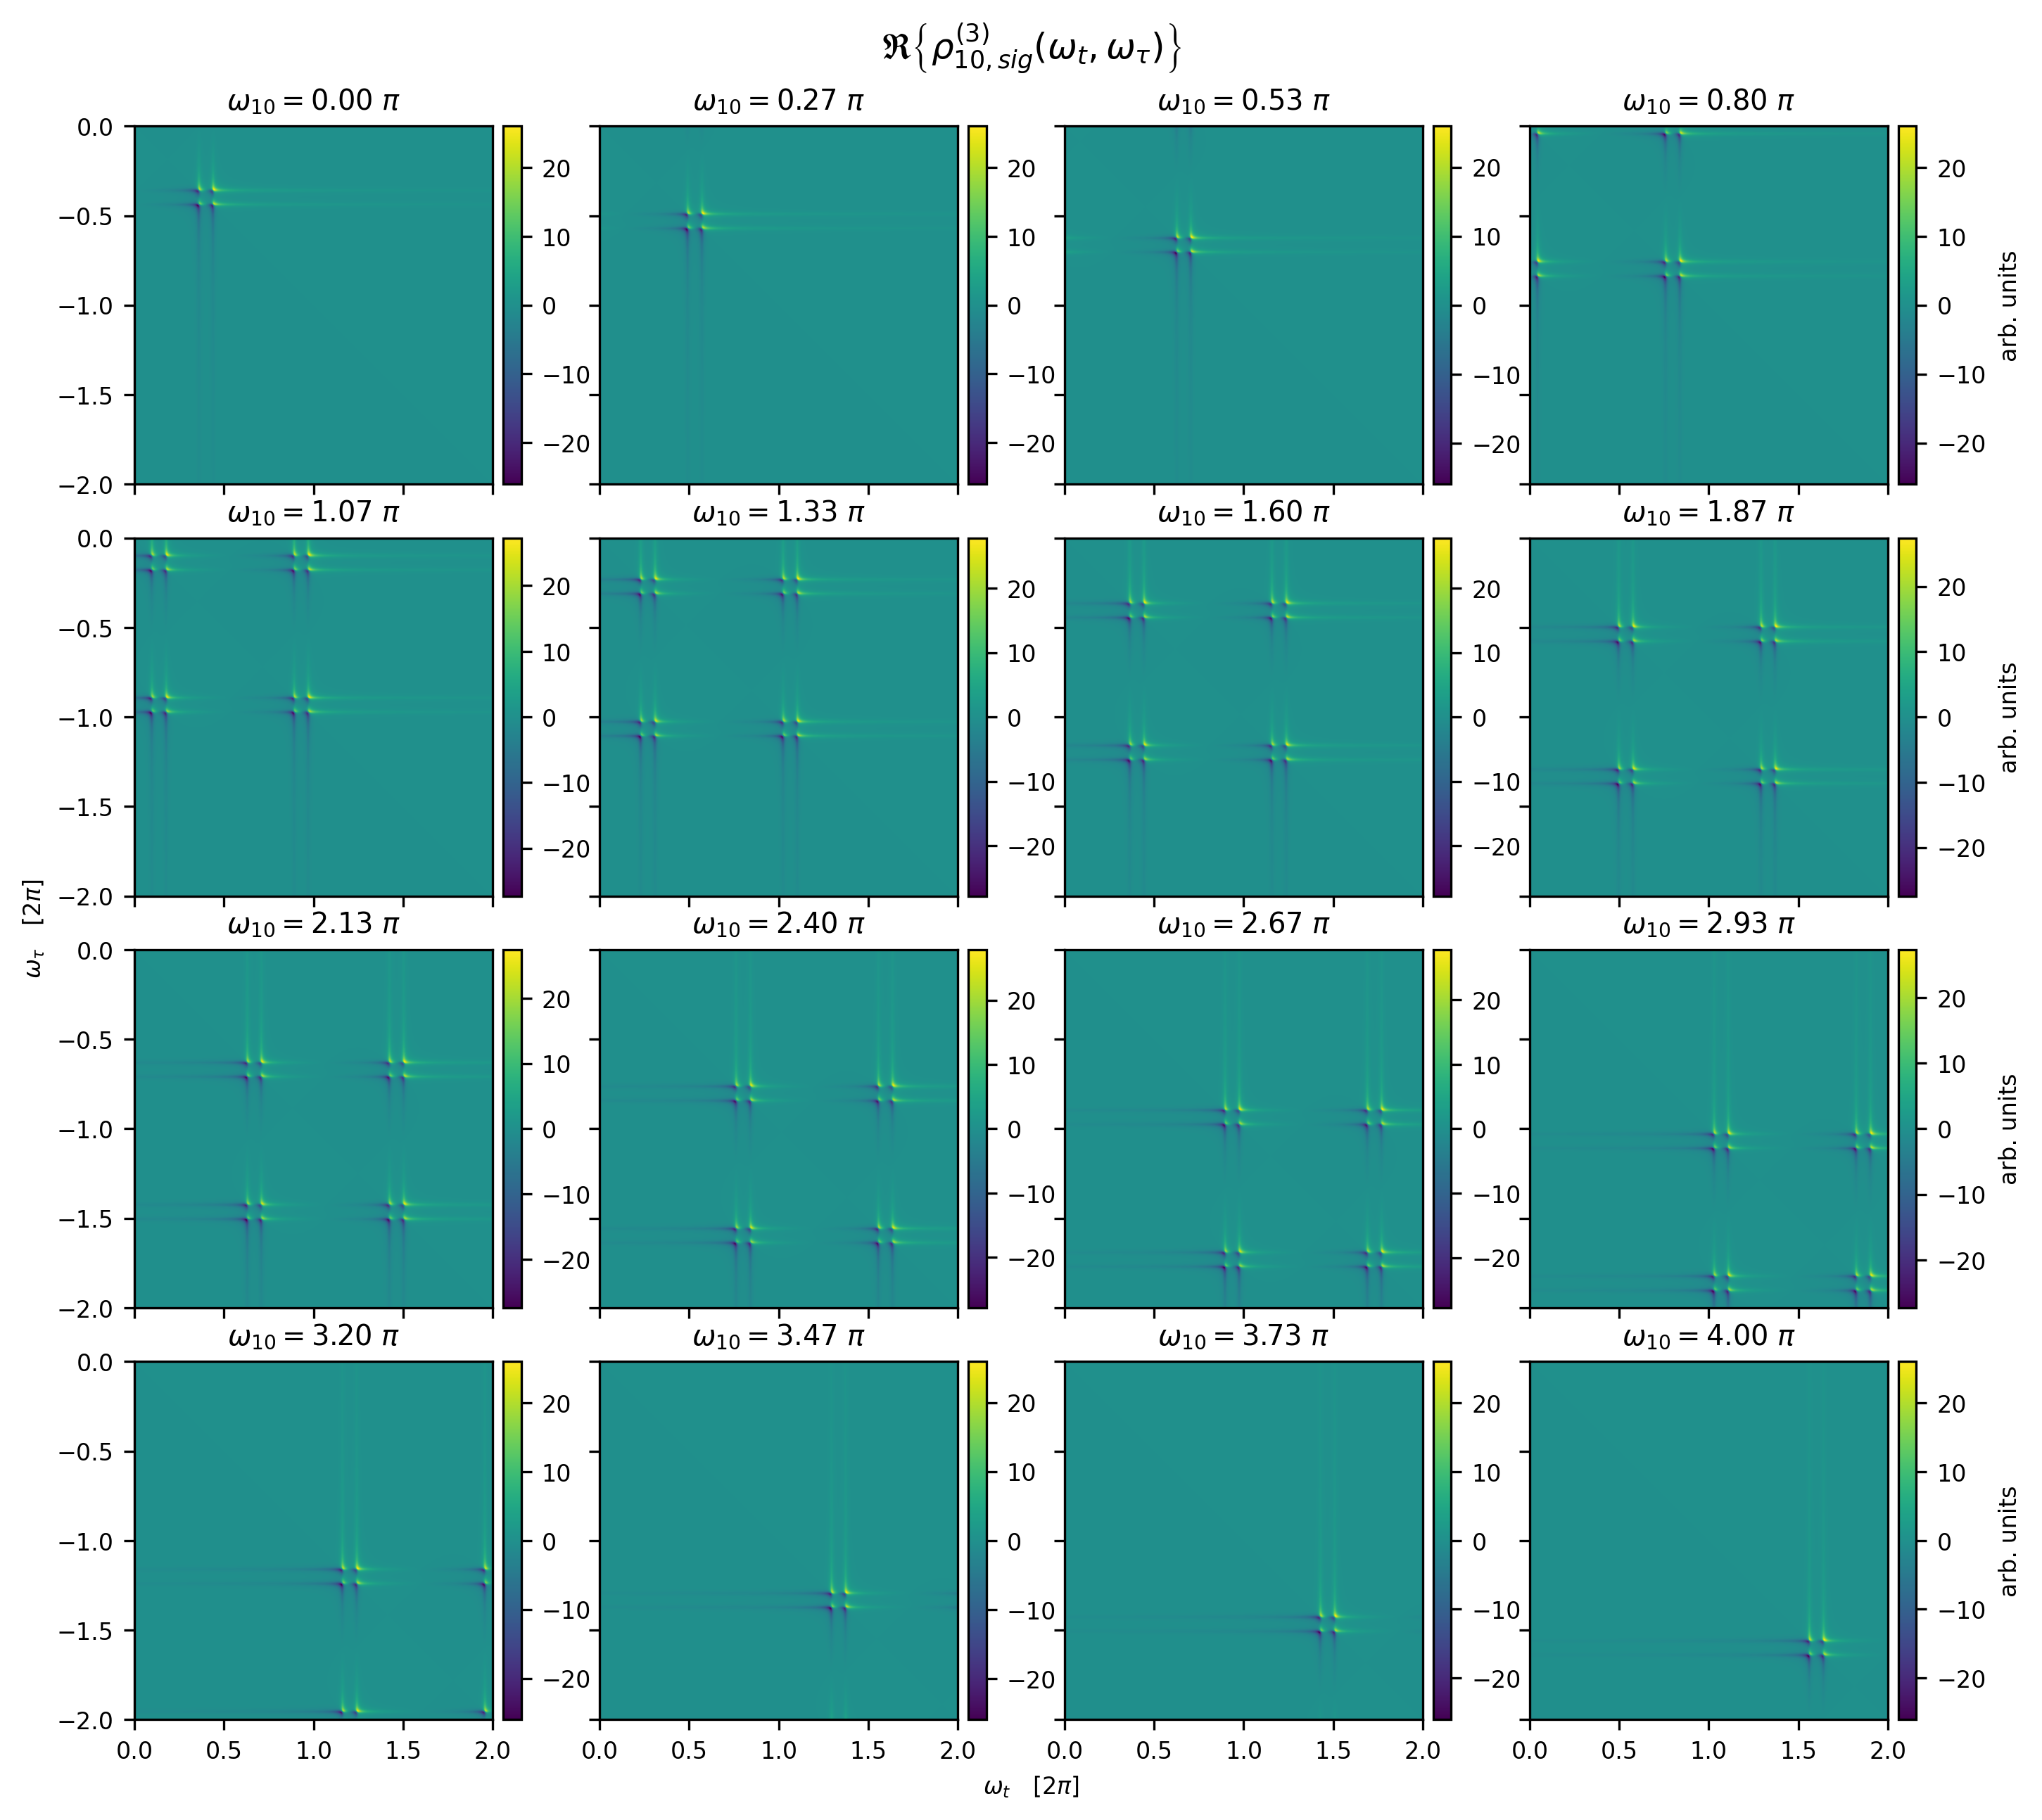

In [51]:
RHO_10_SIG_3 = rho_10_sig_3(omega_t_3Dmesh, omega_tau_3Dmesh, omega_10_3Dmesh)
figDense = slices_plots(RHO_10_SIG_3.real)

# figDense.savefig("/Users/tommychin/Documents/research/Smallwood_research/denseMatrAtmp2.eps", 
#                  format='eps', 
#                  bbox_inches='tight')

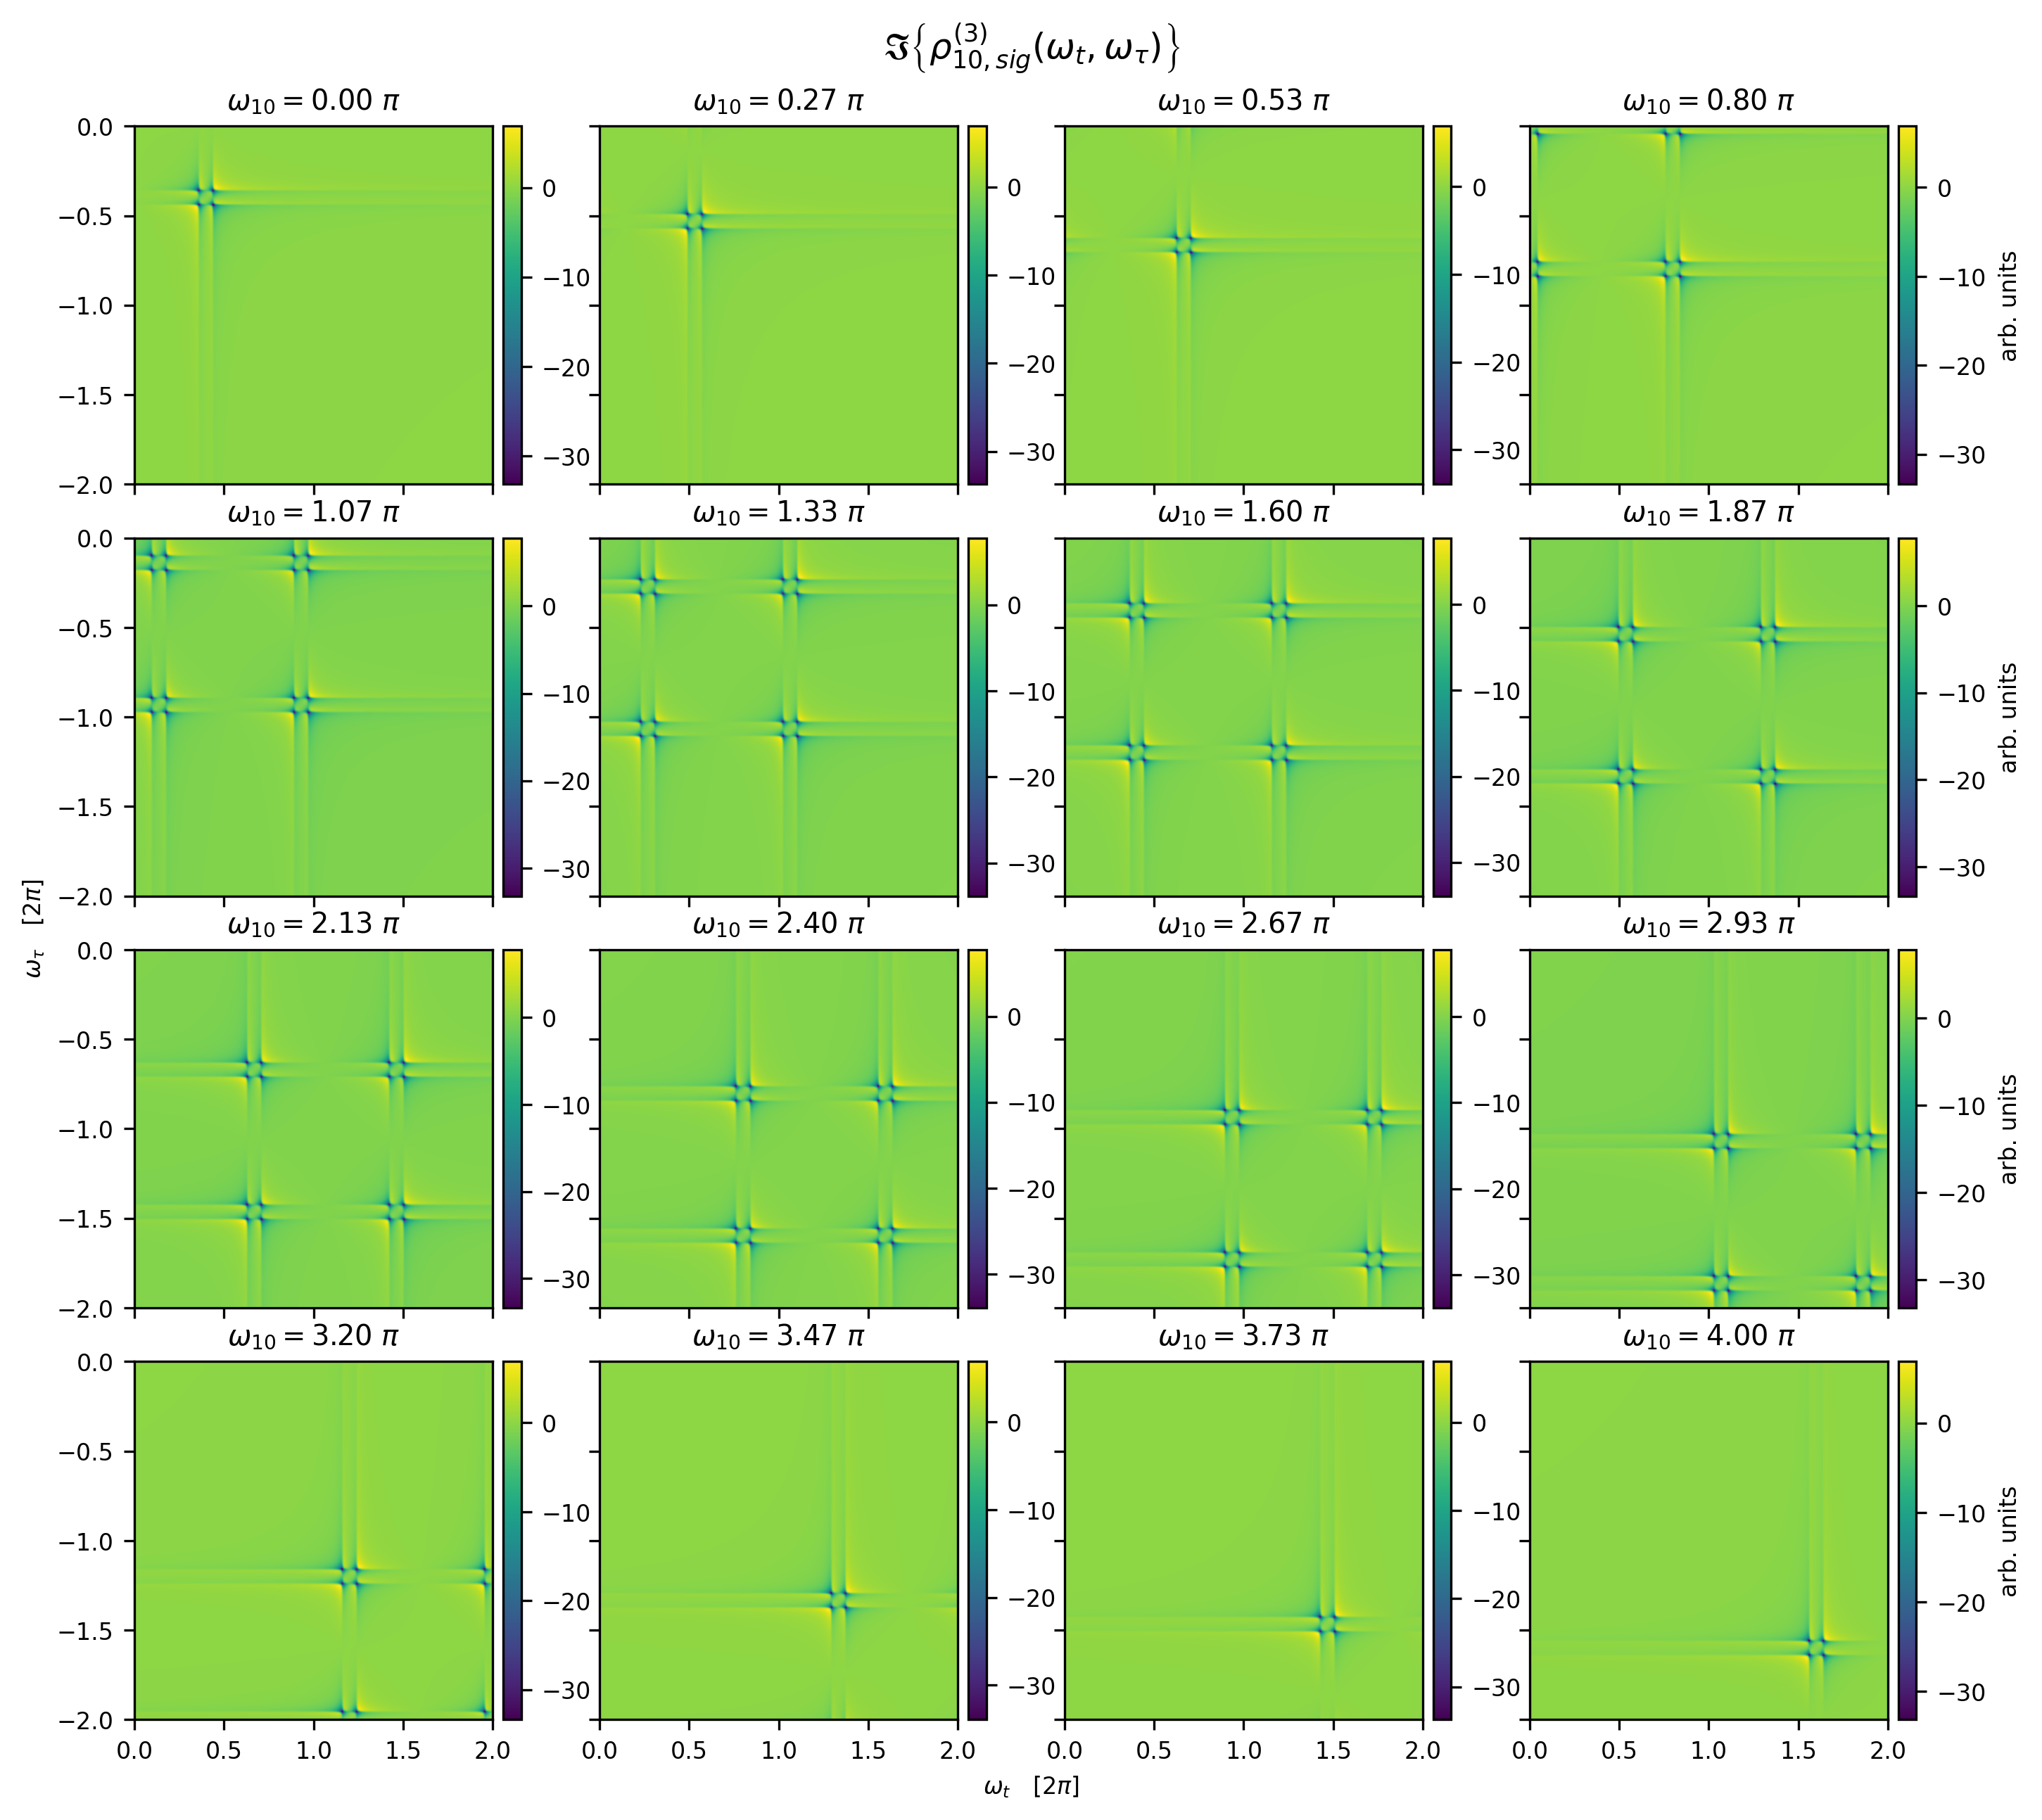

In [52]:
_ = slices_plots(RHO_10_SIG_3.imag, 
                 shared_title=r'$\mathfrak{I} \left\{ \rho^{(3)}_{10,sig} (\omega_t, \omega_\tau) \right\}$')

## index 11, 4th order correction

# $ \rho^{(4)}_{11,sig} (\omega_t, \omega_\tau) = \frac{|\mu|^4}{16 \hbar^4} \left( \frac{i}{\omega_t - \left[ \omega_{10} - i \gamma_{10} \right] } \right) \left( \frac{i}{\omega_\tau - \left[ -\omega_{10} - i \gamma_{10} \right] } \right) \tag{s15} $

In [53]:
@numba.jit
def rho_11_sig_4(omega_t, omega_tau, omega10):
    return abs2(mu)**2. / 16. / hbar**4. * (1j / (omega_t - (omega10 - 1j*gamma10))) * (1j / (omega_tau - (-omega10 - 1j*gamma10)))

# electron-phonon coupling function

## equation is written in text at the very beginning of p. 15 of the Supplementary Material

# $ R (\omega_{10}, \, \omega_{12}) = R (\omega_{12}) \propto \omega_{12}^2$

In [54]:
@numba.jit
def R(omega10, omega12):
    return omega12**2.

# $\tilde{E}^*_{LO}$ is the electric field?

# branching ratio

# $B(\omega_{10}, \omega_{12}) = \frac{\Gamma_{10}}{\Gamma_{10} \, + \, \Gamma_{12} (\omega_{10}, \, \omega_{12})} \approx \frac{\Gamma_{10}}{\Gamma_{10} \, + \, R (\omega_{10}, \, \omega_{12})} \tag{s16} $

In [55]:
@numba.jit
def B(omega10, omega12):
    return Gamma10 / (Gamma10 + R(omega10, omega12))

# Gaussian

# $ G \left (\omega_{10} - \omega_{10}^{(unstrained)} \right ) \equiv \frac{N}{\sigma \sqrt{2 \pi}} exp \left[ \frac{-\left (\omega_{10} - \omega_{10}^{(unstrained)} \right )^2}{2 \sigma^2} \right] \tag{s19} $

# Modified Gaussian

# $ G \left (\omega_{10} - \omega_{10}^{(unstrained)}\right ) \equiv \frac{N}{0.5\sigma \sqrt{2 \pi}} exp \left[ \frac{- \left (\omega_{10} - 0.5\omega_{10}^{(unstrained)} \right ) ^2}{2 \left(0.5 \sigma \right)^2} \right] + \frac{N}{1.5\sigma \sqrt{2 \pi}} exp \left[ \frac{-\left (\omega_{10} - 1.5\omega_{10}^{(unstrained)} \right ) ^2}{2 (1.5\sigma)^2} \right] $ $\tag{Mod. s19}$

In [56]:
@numba.jit
def G(omega10):
    return N / sigma / np.sqrt(2. * np.pi) * np.exp(-(omega10 - omega10_unstrained)**2. / 2. / sigma**2.)
#     return np.sum([ N / 0.5 / sigma / np.sqrt(2.*np.pi) * np.exp(-(omega10 - 0.5*omega10_unstrained)**2. / 2. / (0.5*sigma)**2.), 
#                     N / 1.5 / sigma / np.sqrt(2.*np.pi) * np.exp(-(omega10 - 1.5*omega10_unstrained)**2. / 2. / (1.5*sigma)**2.)
#                   ], 0)

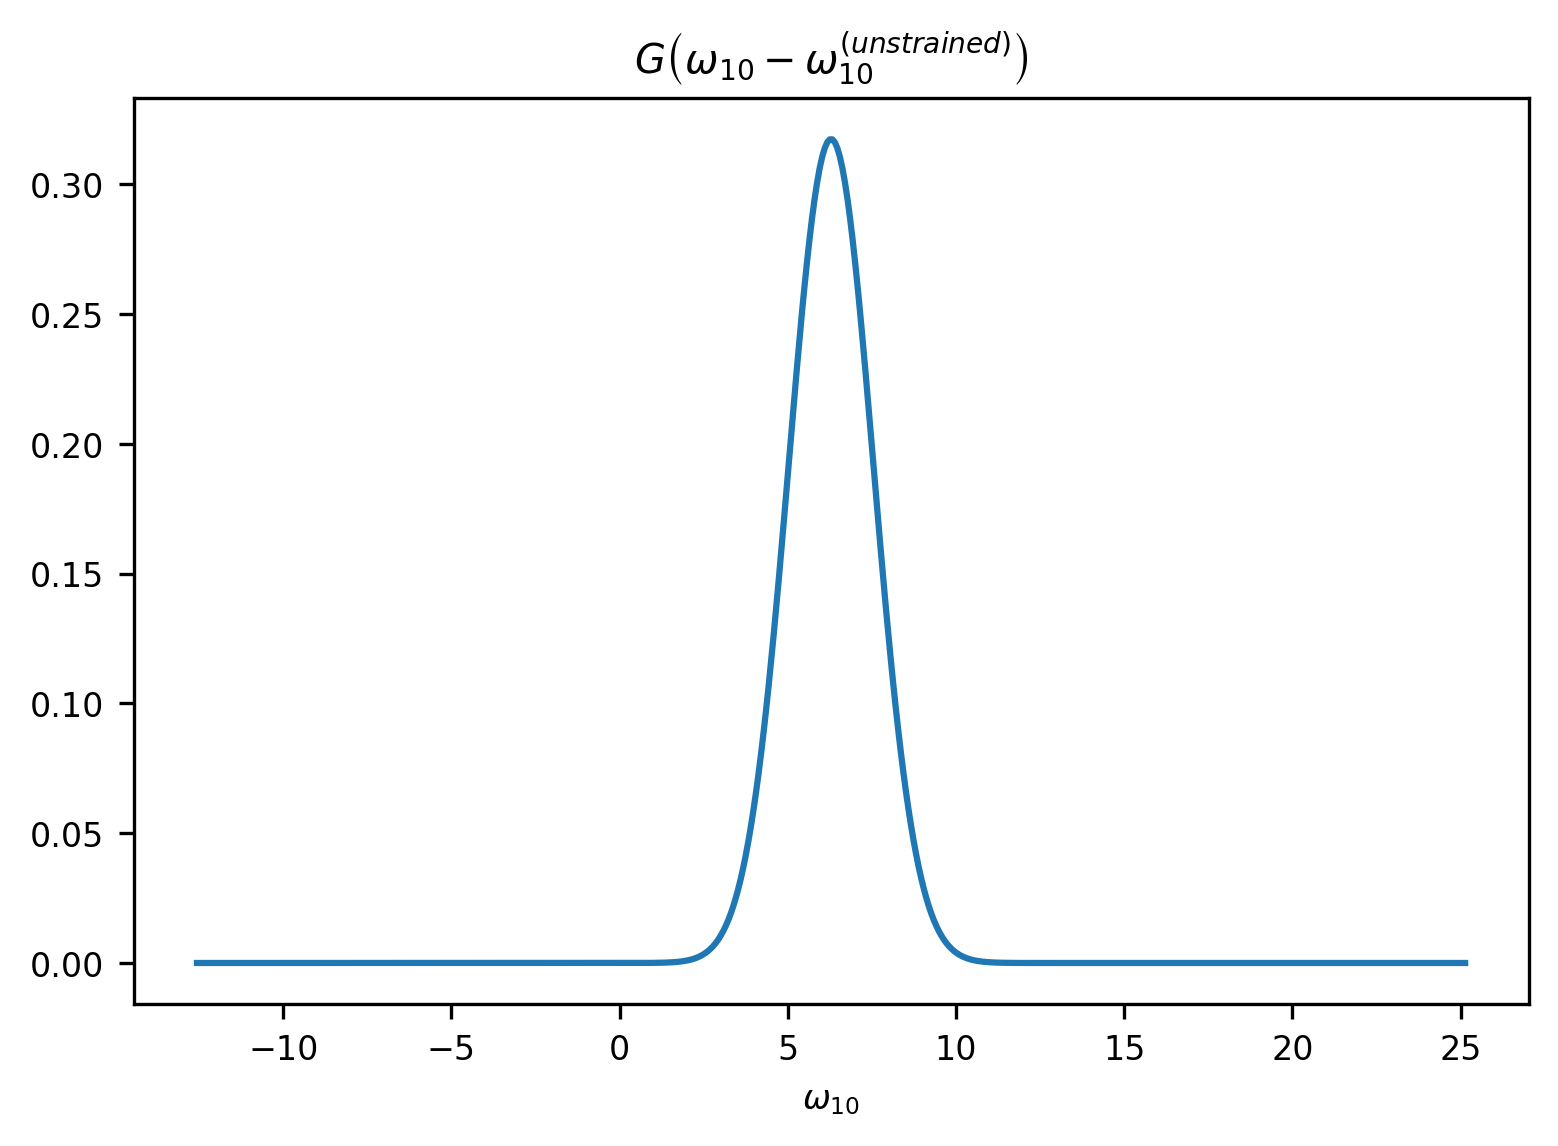

In [57]:
OMEGA10 = np.linspace(-4.*np.pi, 8.*np.pi, 500)
plt.plot(OMEGA10, G(OMEGA10))
plt.title(r'$ G \left (\omega_{10} - \omega_{10}^{(unstrained)} \right ) $')
plt.xlabel(r'$ \omega_{10} $')
plt.show()

# Infinite integral

In [58]:
@numba.jit
def infint(argu):
    return spint.quad_vec(argu, -np.inf, np.inf)

# computing the integral using https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad_vec.html

# $I_{tot, het}(\omega_t, \omega_\tau) \propto \tilde{E}^*_{LO} (-\omega_t) \displaystyle \int^{\infty}_{-\infty} G \left (\omega_{10} - \omega_{10}^{(unstrained)} \right ) \left [ i \mu^* \rho^{(3)}_{10,sig} (\omega_t, \omega_\tau, \omega_{10}) \right ] d \omega_{10} $ $\tag{s20}$

In [59]:
argu = lambda omega10: G(omega10) * 1j * np.conj(mu) * rho_10_sig_3(omega_t_mesh, omega_tau_mesh, omega10)
I_tot_het, int_err_het = infint(argu)

/var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_4503/3005950524.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "infint" failed type inference due to: non-precise type pyobject
During: typing of argument at /var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_4503/3005950524.py (3)

File "../../../../../../var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_4503/3005950524.py", line 3:
<source missing, REPL/exec in use?>

  @numba.jit
/Users/tommychin/opt/anaconda3/lib/python3.8/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "infint" was compiled in object mode without forceobj=True.

File "../../../../../../var/folders/ll/xnd2vddx2v58kn3khq6ldnc00000gn/T/ipykernel_4503/3005950524.py", line 1:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaWarning(warn_msg,
/Users/tommychin/opt/anaconda3/lib/python3.8/site-packages/numba/core/object_mode_passes.py:161: NumbaDep

# $I_{tot, PL}(\omega_t, \omega_\tau) \propto \displaystyle \int^{\infty}_{-\infty} G \left (\omega_{10} - \omega_{10}^{(unstrained)} \right ) B(\omega_{10}, \omega_{12}) \, \rho^{(4)}_{11,sig} (\omega_t, \omega_\tau, \omega_{10}) d \omega_{10} $ $\tag{s21}$

argu = lambda omega10: G(omega10) * B(omega10, omega12) * rho_11_sig_4(omega_t_mesh, omega_tau_mesh, omega10)
I_tot_PL, int_err_PL = infint(argu)

# Plotting Heterodyne detection vs. PL detection simulation results

## Fig. S9(a)

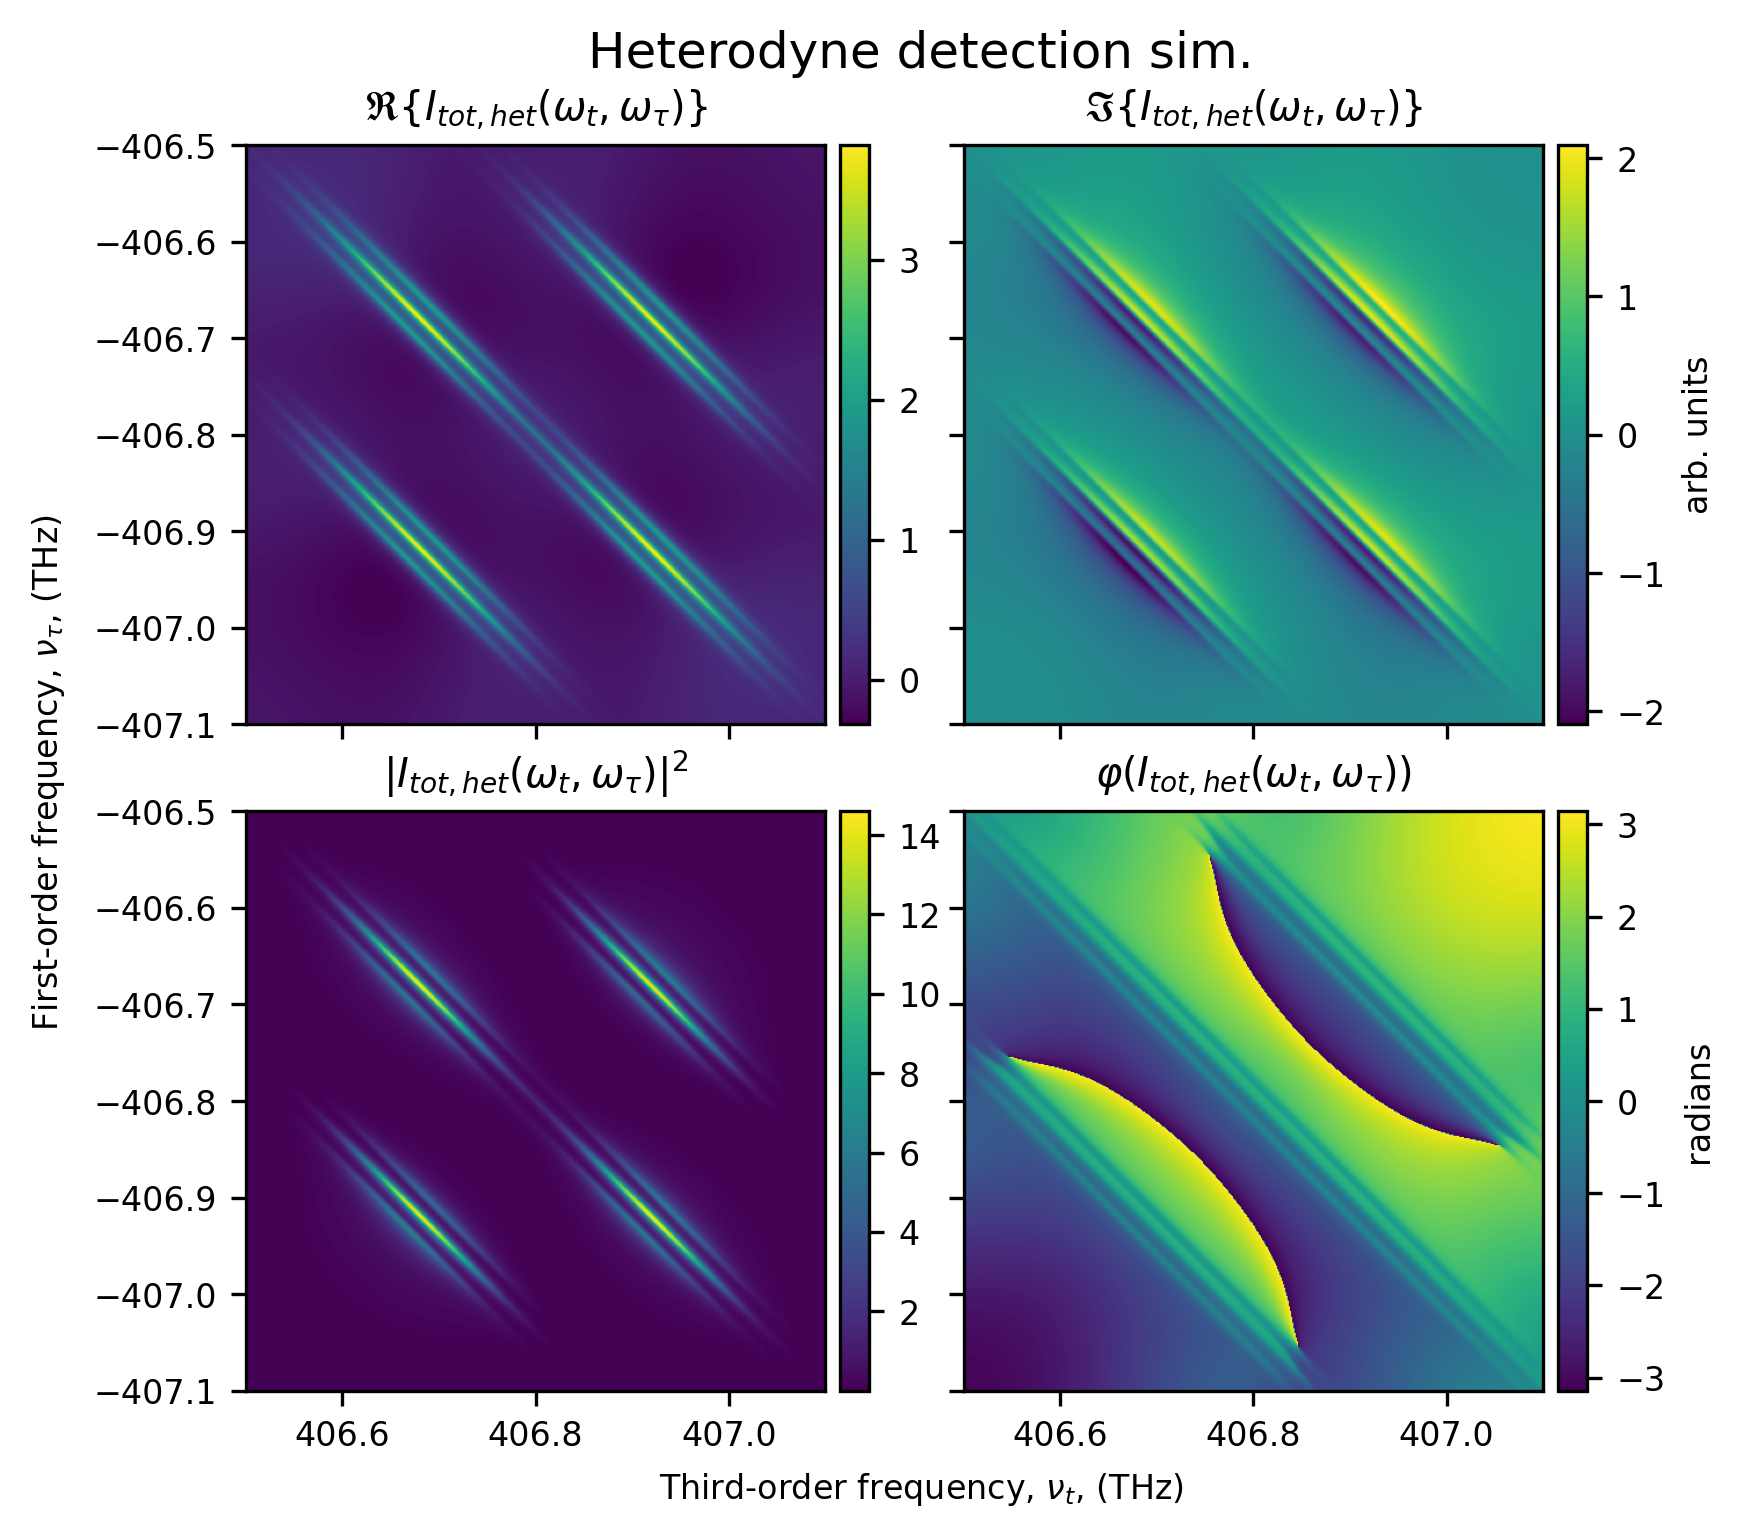

In [60]:
I_tot_het_ReImAm = np.array([I_tot_het.real, I_tot_het.imag, abs2(I_tot_het), phi(I_tot_het)])
figHet = slices_plots(I_tot_het_ReImAm, 
                      shared_title='Heterodyne detection sim.', 
                      shared_title_y_position=0.95,
                      figure_shape=[2,2], 
                      figure_size=[6,5.5],
                      titles=[r'$\mathfrak{R} \left\{I_{tot, het} (\omega_t, \omega_\tau) \right\}$', 
                              r'$\mathfrak{I} \left\{I_{tot, het} (\omega_t, \omega_\tau) \right\}$',
                              r'$             \left |I_{tot, het} (\omega_t, \omega_\tau) \right |^2$',
                              r'$     \varphi \left (I_{tot, het} (\omega_t, \omega_\tau) \right )$'],
                      horizontal_gap=0.06,
                      shared_y_label_x_position=0.02, 
                      shared_x_label_y_position=0.06, 
                      EXTENT=(406.5, 407.1, -407.1, -406.5), 
                      shared_x_label=r'Third-order frequency, $\nu_t$, (THz)', 
                      shared_y_label=r'First-order frequency, $\nu_\tau$, (THz)',
                      colorbar_labels=[None, 'arb. units', None, 'radians'])

figHet.savefig("/Users/tommychin/Documents/research/Smallwood_research/crossPeaksAttempt4.eps", 
               format='eps', 
               bbox_inches='tight')

fig = plt.figure()
im = plt.imshow(I_tot_het.real, origin='lower', extent=(406.5, 407.1, -407.1, -406.5))
plt.xlabel(r'Third-order frequency, $\nu_t$, (THz)')
plt.ylabel(r'First-order frequency, $\nu_\tau$, (THz)')
plt.title('Heterodyne detection sim.')
colorbar(im)
plt.show()
# fig.savefig("/Users/tommychin/Documents/research/Smallwood_research/testVectorImage.eps", format='eps', bbox_inches='tight')

## Fig. S9(b)

In [61]:
I_tot_PL_ReImAm = np.array([I_tot_PL.real, I_tot_PL.imag, abs2(I_tot_PL), phi(I_tot_PL)])
figPL = slices_plots(I_tot_PL_ReImAm, 
                      shared_title='PL detection sim.', 
                      shared_title_y_position=0.95,
                      figure_shape=[2,2], 
                      figure_size=[6,5.5],
                      titles=[r'$\mathfrak{R} \left\{I_{tot, PL} (\omega_t, \omega_\tau) \right\}$', 
                              r'$\mathfrak{I} \left\{I_{tot, PL} (\omega_t, \omega_\tau) \right\}$',
                              r'$             \left |I_{tot, PL} (\omega_t, \omega_\tau) \right |^2$',
                              r'$     \varphi \left (I_{tot, PL} (\omega_t, \omega_\tau) \right )$'],
                      horizontal_gap=0.06,
                      shared_y_label_x_position=0.04, 
                      shared_x_label_y_position=0.06)

NameError: name 'I_tot_PL' is not defined